# Manuel Agraz Vallejo

# AI534 IA3: Text Classification with BoW, Linear SVM and Naive Bayes



##Overview:
You will use use the sklearn package to implement and compare classic text classification models, practicing principled evluation, tuning and interpretation. Specifically, your work will include:
* clean preprocessing pipeline to produce BoW and TF-IDF features
* Linear/RBF SVM and Multinomial Naive Bayes classifiers
* Hyperparameter sweeps+plots
* Error analysis, feature interpretatoin and short reflection.

## Data
The data for this assignment consists of a natural language sentiment dataset sourced from Twitter. The first column indicates sentiment of the tweets (zero representing negative sentiment and one for positive sentiment) and the second column contains the text of the tweets.

Two datasets are provided on Canvas: a training set named 'IA3-training.csv' and a validation set named 'IA3-dev.csv'. You will use the training set to build your models and the validation set to tune the parameters and observe their impacts.


## What you need to submit
1. Your completed notebook in ipynb
2. a PDF report that includes all code outputs and figures. You can use the code block at the end of the notebook to generate a PDF export of the notebook with the outputs for your report. However, if any figures or outputs are missing, you must either:
* Manually add the missing figures to the PDF using a PDF editor or
* Copy your notebook contents into a Word or Google Doc, insert the missing outputs there, and export that document as a PDF.

First let's import the packages needed for this assignment.

In [1]:
# !pip install nbconvert > /dev/null 2>&1
# !pip install pdfkit > /dev/null 2>&1
# !apt-get install -y wkhtmltopdf > /dev/null 2>&1
# from google.colab import files

import os
import pdfkit
import contextlib
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns


Let's load the data.

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# train_path = '/content/gdrive/My Drive/AI534/IA3_train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
# val_path = '/content/gdrive/My Drive/AI534/IA3_val.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

train_path = './IA3_train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = './IA3_val.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)

# Part 0: (10 pts) Preprocessing and Initial Anlaysis
In this part, you will take the text of the tweets and convert it to the bag-of-words (BoW) representation that can be processed by the model you will train.



##📘 Detailed instructions
First, you will build your BoW vocabulary using the training set and represent your training set using *tf-idf*.

Here ***tf*** stands for term frequecy and is defined as follows for a document $d$ and term $t$:

$TF(t,d) = \frac{\mbox{Num. of times } t \mbox{ appears in } d}{\mbox{Total number of terms in }d}$

and ***idf*** stands for inverse document frequency and is defined as follows for a term $t$ and a document collection $D$

$IDF(t, D) = \log(\frac{N}{|\{d\in D: t\in d\}|}) $


where $N$ is the total number of documents in $D$, and $|\{d\in D: t\in d\}|$ is the number of documents that contain term $t$.
Specifically, you will be using the **TfidfVectorizer** class from the sklearn.feature_extraction.text package (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#). For this assignment, you should set '***stop_words=english***', other parameters can remain at their default values.

The specific methods you will need to use include:
- **`fit_transform()`** — learns the vocabulary and inverse document frequencies from the input documents (fit), and produces their TF–IDF representation (transform).
- **`transform()`** — applies the learned vocabulary and IDF values to new documents to produce their TF–IDF representation.

Both methods return a sparse matrix representation of the documents, which can be directly used by the SVM package and the Naive Bayes Package for learning. Using a sparse matrix representation is computationally efficient, especially for SVM models.

## 🚧 Task: Build TF-IDF Features & Build Intial Word Insights
**Your tasks:**

1. Use class `TfidfVectorizer(stop_words='english')` and apply:
   - `fit_transform()` to the **training** tweets to learn the vocabulary and IDF weights and produce the TF-IDF representation for training data
   - `transform()` to the **validation** tweets using the learned vocabulary and IDF values and produce the TF-IDF representation of the validation data

2. Print the shapes of the resulting TF–IDF matrices for the training and validation sets.

3. On the **training data only**, for each sentiment class (**positive** and **negative**):
   - Compute a **cumulative TF–IDF score** for each word:
   `CumulativeTFIDF(t, C)` = $\sum_{d \in C} \text{TFIDF}(t, d)$

     
   - Rank all words by this score and list the **top 20 words** in each class

4. Compare the two lists and report:
   - Words that appear in **both** lists
   - Words **distinctive to positive** sentiment
   - Words **distinctive to negative** sentiment

> ✅ Your output should include matrix shapes, the two ranked word lists (computed from training data only), and the comparison.



In [3]:
# Your code goes here
vectorizer = TfidfVectorizer(stop_words='english', input="content")

tf_idf_train = vectorizer.fit_transform(train_data['tweet'])

tf_idf_val = vectorizer.transform(val_data['tweet'])

# Get feature names
feature_names = vectorizer.get_feature_names_out()

print(f"TF-IDF train shape: {tf_idf_train.shape}")
print(f"TF-IDF val shape: {tf_idf_val.shape}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

# Split data by sentiment - convert to numpy arrays
positive_mask = (train_data['label'] == 1).to_numpy()
negative_mask = (train_data['label'] == 0).to_numpy()

# Get TF-IDF matrices for each class
tf_idf_positive = tf_idf_train[positive_mask]
tf_idf_negative = tf_idf_train[negative_mask]

# Compute cumulative TF-IDF for each class
cumulative_tfidf_positive = np.asarray(tf_idf_positive.sum(axis=0)).flatten()
cumulative_tfidf_negative = np.asarray(tf_idf_negative.sum(axis=0)).flatten()

# Create rankings for positive sentiment
positive_indices = np.argsort(cumulative_tfidf_positive)[::-1]  # Sort descending
top_20_positive = [(feature_names[i], cumulative_tfidf_positive[i]) for i in positive_indices[:20]]

# Create rankings for negative sentiment
negative_indices = np.argsort(cumulative_tfidf_negative)[::-1]  # Sort descending
top_20_negative = [(feature_names[i], cumulative_tfidf_negative[i]) for i in negative_indices[:20]]

# Display results
print("\nTOP 20 WORDS FOR POSITIVE SENTIMENT")
for rank, (word, score) in enumerate(top_20_positive, 1):
    print(f"{rank:2d}. {word:20s}: {score:.4f}")

print("\nTOP 20 WORDS FOR NEGATIVE SENTIMENT")
for rank, (word, score) in enumerate(top_20_negative, 1):
    print(f"{rank:2d}. {word:20s}: {score:.4f}")

# Compare the lists
positive_words = set([word for word, _ in top_20_positive])
negative_words = set([word for word, _ in top_20_negative])

common_words = positive_words & negative_words
positive_only = positive_words - negative_words
negative_only = negative_words - positive_words

print("\nCOMPARISON OF TOP 20 WORDS")
print(f"\nWords in BOTH lists ({len(common_words)}):")
print(", ".join(sorted(common_words)) if common_words else "None")

print(f"\nWords DISTINCTIVE to POSITIVE sentiment ({len(positive_only)}):")
print(", ".join(sorted(positive_only)) if positive_only else "None")

print(f"\nWords DISTINCTIVE to NEGATIVE sentiment ({len(negative_only)}):")
print(", ".join(sorted(negative_only)) if negative_only else "None")


TF-IDF train shape: (6030, 8508)
TF-IDF val shape: (1702, 8508)
Vocabulary size: 8508

TOP 20 WORDS FOR POSITIVE SENTIMENT
 1. thanks              : 96.3201
 2. thank               : 88.8932
 3. jetblue             : 71.1725
 4. southwestair        : 60.6011
 5. united              : 44.4496
 6. great               : 40.4915
 7. americanair         : 36.8272
 8. usairways           : 33.1923
 9. flight              : 26.7756
10. virginamerica       : 22.3447
11. http                : 21.8767
12. love                : 21.2612
13. just                : 21.1207
14. awesome             : 20.3262
15. service             : 18.4246
16. good                : 16.5092
17. guys                : 16.2970
18. best                : 15.4708
19. got                 : 14.7444
20. amazing             : 14.2398

TOP 20 WORDS FOR NEGATIVE SENTIMENT
 1. flight              : 195.5376
 2. united              : 191.6732
 3. usairways           : 172.0774
 4. americanair         : 158.2648
 5. southwestair    

## ✍️ Questions

1. Consider the three sets of words you identified:  
   **(a)** common to both classes, **(b)** positive-only, and **(c)** negative-only.  
   What patterns do you observe in each group? (e.g., emotional tone, topic, intensity)

2. Suppose you train a linear sentiment classifier (e.g., linear SVM).  
   How do you expect it to use these words?  
   Discuss the likely **sign** and **magnitude** of the weights assigned to
   - positive-only words  
   - negative-only words  
   - words appearing in both classes

**1.-**

**The words that are common to both classes, tend to be nouns such as the names of the airlines and the word "flight" which make sense since most tweets towards an airline are bound to have these words. For these words there is no emotional tone and no intensity, as they don't convey emotion.**

**The positive only words are mostly adjectives like: "great", "amazing", "good" and "best". All of these words have a positive tone, and moderate intensity, as they come from good reviews or praises for the companies by the customers. It's worth noting that the company "virginamerica" is generally asociated with postive comments which speaks good of it's service.**

**The negative words are mostly related with issues that one could have with a flight such as cancellations, lost bags, delays, and long waiting hours. While the tone is negative, the words' intensity is neutral, there aren't any strong words being used against the companies, or they where probably censored.**

**2.-**

**I expect the classifier to use the positve-only and negative-only words as the support vectors of the boundary. As classifying these correctly is likely to lead to a correct classifcation. On the other hand words appearing in both classes would be closer to the boundary as the model would be less certain of their class.**

**I expect the positive-only words to have high positve weights. For the negative-only words i expect them to have highly negative weights. These high weight values stem from the fact that the model would be able to classify them easily as they are directly related to their respective labels. For the words appearing in both class i expect their weights to be small, close to zero, as the classifier would learn that these words can't be relied on to make a classification.**


# Part 1. (30 pts) Linear SVM with C sweep

You will train **linear SVM** models on the TF–IDF features and tune the regularization parameter **C** over
$C \in \{10^{-2}, 10^{-1}, 10^{0}, 10^{1}, 10^{2}, 10^{3}\}.$

Use `sklearn.svm.SVC` with `kernel='linear'` so that you can access the **number of support vectors** (this is not available in `LinearSVC`). The linear SVM can consume sparse TF–IDF matrices directly.

### 🚧 Task: Linear SVM and parameter sweep
Complete the following:

1. Train a `SVC(kernel='linear')` model for each  
   
   $C \in \{10^{-2},\,10^{-1},\,1,\,10,\,10^2,\,10^3\}$

2. For each $C$:
   - Train on the **training** set
   - Compute **AUROC** on **training** and **validation** sets  
   - Record the **total number of support vectors**

3. Create two plots (log-scale on the \(C\)-axis):
   - **Training vs validation AUROC** as a function of \(C\)
   - **Total number of support vectors** as a function of \(C\)

4. Select and report the **best \(C\)** based on **validation AUROC**  

In [4]:
# Your code goes here.
from sklearn.metrics import roc_auc_score
import sklearn.svm

# Define C values to test
C_values = [10**-2, 10**-1, 1, 10, 10**2, 10**3]

# Store results
results = []

# Get labels
y_train = train_data['label'].to_numpy()
y_val = val_data['label'].to_numpy()

for C in C_values:
    # Train linear SVM
    model = svm.SVC(kernel='linear', C=C, random_state=42)
    model.fit(tf_idf_train, y_train)
    
    # Get decision function scores for AUROC
    train_scores = model.decision_function(tf_idf_train)
    val_scores = model.decision_function(tf_idf_val)
    
    # Calculate AUROC
    train_auroc = roc_auc_score(y_train, train_scores)
    val_auroc = roc_auc_score(y_val, val_scores)
    
    # Get number of support vectors
    n_support_vectors = len(model.support_)
    
    # Store results
    results.append({
        'C': C,
        'train_auroc': train_auroc,
        'val_auroc': val_auroc,
        'n_support_vectors': n_support_vectors
    })

# Create results DataFrame
results_df = pd.DataFrame(results)

# Display results table
print("\nSUMMARY TABLE")
print(results_df.to_string(index=False))
print("\n")

# Find best C based on validation AUROC
best_idx = results_df['val_auroc'].idxmax()
best_C = results_df.loc[best_idx, 'C']
best_val_auroc = results_df.loc[best_idx, 'val_auroc']

print(f"Best C value: {best_C:.0e}")
print(f"Best validation AUROC: {best_val_auroc:.4f}")




SUMMARY TABLE
      C  train_auroc  val_auroc  n_support_vectors
   0.01     0.955315   0.937794               2769
   0.10     0.966381   0.945313               2623
   1.00     0.993342   0.953932               2340
  10.00     0.999261   0.939581               2069
 100.00     0.999400   0.924712               1919
1000.00     0.999531   0.918940               1732


Best C value: 1e+00
Best validation AUROC: 0.9539


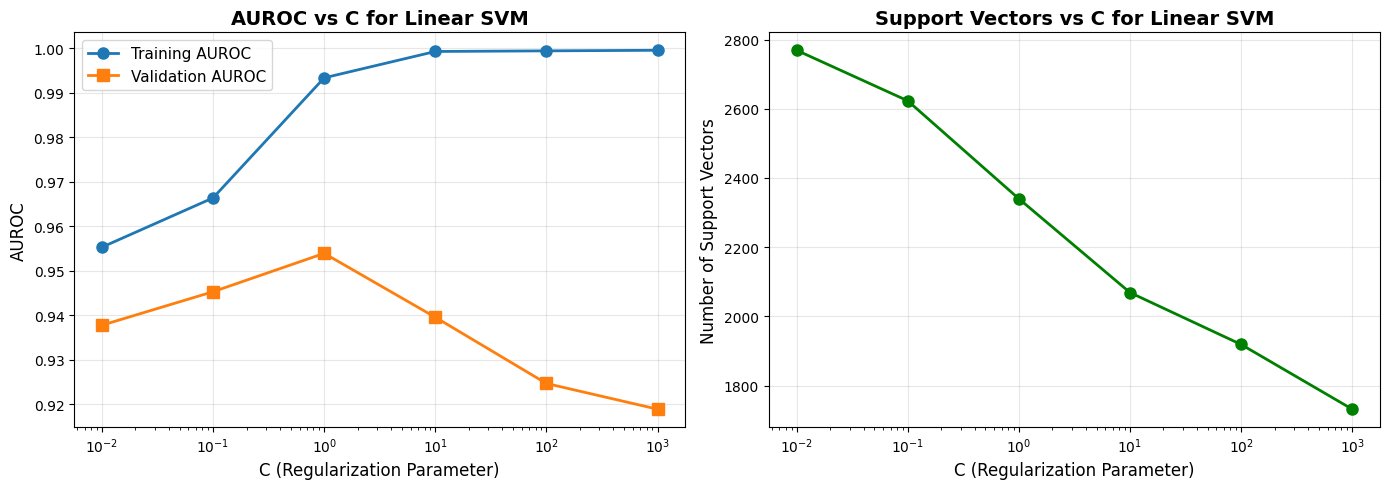

In [5]:
# Create plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: AUROC vs C
axes[0].plot(results_df['C'], results_df['train_auroc'], 'o-', 
             label='Training AUROC', linewidth=2, markersize=8)
axes[0].plot(results_df['C'], results_df['val_auroc'], 's-', 
             label='Validation AUROC', linewidth=2, markersize=8)
axes[0].set_xscale('log')
axes[0].set_xlabel('C (Regularization Parameter)', fontsize=12)
axes[0].set_ylabel('AUROC', fontsize=12)
axes[0].set_title('AUROC vs C for Linear SVM', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Number of support vectors vs C
axes[1].plot(results_df['C'], results_df['n_support_vectors'], 'o-', 
             color='green', linewidth=2, markersize=8)
axes[1].set_xscale('log')
axes[1].set_xlabel('C (Regularization Parameter)', fontsize=12)
axes[1].set_ylabel('Number of Support Vectors', fontsize=12)
axes[1].set_title('Support Vectors vs C for Linear SVM', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## ✍️ Questions
1. As the regularization parameter $C$ increases, what trends do you expect in   (a) training performance and
  (b) validation performance?
  Explain why in terms of underfitting vs. overfitting.  
  Then compare your theoretical expectation to your observed results.  
  If they differ, provide a plausible explanation.
2. If different $C$ values produce very similar AUROC values, what principle would you use to choose between them, and why?

3. How do you expect the number of support vectors to change as $C$ increases? Explain why based on the SVM objective and margin behavior.  
Then compare your expectation to your observed results and discuss any discrepancies.



**1.-**

**As we increase the C parameter we penalize slack more and more. Penalizing slack leads to overfitting as the model tries to find a boundary where no data points have a slack greater than zero. Given increasing C leads to overfitting, I expect the training performance to increase as C increases and the validation performance to decrease.**

**2.-**

**If different C values produce very similar AUROC values, I would choose the smallest C value. Mainly because a smaller C values means we allow higher values of slack. This reduces overfitting and leads to a more generalizable model.**

**3.-**

**As C increases I expect the number of support vectors to decrease. The SVM objective seeks to maximize the margin while minimizing classification errors. When C is small, the penalty for misclassification is low, so the model prioritizes finding a wide margin even if it means allowing many points to violate the margin or be misclassified. This results in a soft margin with many support vectors - including points on the margin, within the margin, and on the wrong side.**

**As C increases, the penalty for slack variables becomes larger, forcing the model to work harder to classify training points correctly. This leads to a harder margin with fewer violations. Consequently, fewer points end up being support vectors because the model can achieve correct classification for more points without needing them to define the decision boundary.**

**The results confirm my expectation, the Support Vectors vs C plot shows that as we increase C, the number of suport vectors decreases.**


## 🚧 Task — Further Exploration of the SVM Parameter \(C\)

After completing your initial coarse grid search for \(C\), refine your search to more precisely identify an effective value using validation AUROC as the evaluation criterion.

Use the following guidelines:

- **Boundary Expansion**  
  If the best-performing $C$ value lies at the **edge** of your grid (e.g., the smallest or largest value tested), **extend the search range outward** to explore more extreme values.  
  This checks whether better performance may exist beyond your initial limits.

- **Local Refinement**  
  If the best-performing $C$ value lies **within the interior** of your grid (not at an edge), **refine the search locally** by testing intermediate values near the current best.  
  For example, if $10^1$ performs best in your initial grid, consider trying nearby values such as $10^{0.5}$ and $10^{1.5}$.

- **Iterative Adjustment**  
  Apply expansion or refinement **iteratively**.  
  If a newly tested value becomes the best, repeat the decision process:
  - If the new best lies at a boundary → expand further  
  - If the new best lies inside the range → refine locally again  

Continue exploring until additional adjustments **do not meaningfully improve** validation AUROC.

**Report**
- A small table of tried values and **validation AUROC** (sorted best-to-worst).
- Final chosen value for $C$
- For the best performing linear SVM model, extract the learned feature weights and report the top 10 positive-weight and top 10 negative-weight words

In [6]:
# Your code goes here
# Collect all tried C values and their validation AUROC
all_results = []

# Start with results from initial grid search
for _, row in results_df.iterrows():
    all_results.append({
        'C': row['C'],
        'val_auroc': row['val_auroc'],
        'train_auroc': row['train_auroc']
    })

# Function to train and evaluate a model
def evaluate_C(C_value):
    model = svm.SVC(kernel='linear', C=C_value, random_state=42)
    model.fit(tf_idf_train, y_train)
    
    train_scores = model.decision_function(tf_idf_train)
    val_scores = model.decision_function(tf_idf_val)
    
    train_auroc = roc_auc_score(y_train, train_scores)
    val_auroc = roc_auc_score(y_val, val_scores)
    
    return train_auroc, val_auroc, model

# Iterative refinement
print("ITERATIVE C PARAMETER REFINEMENT")

current_best_C = best_C
current_best_auroc = best_val_auroc
iteration = 1
improvement_threshold = 0.0001  # Stop if improvement is less than this

while True:
    print(f"\nIteration {iteration}:")
    print(f"Current best C = {current_best_C:.4e}, Val AUROC = {current_best_auroc:.6f}")
    
    # Check if best C is at boundary
    tested_C_values = [r['C'] for r in all_results]
    is_at_lower_bound = current_best_C == min(tested_C_values)
    is_at_upper_bound = current_best_C == max(tested_C_values)
    
    new_C_values = []
    
    if is_at_lower_bound:
        # Expand downward
        new_C_values = [current_best_C / 10, current_best_C / 5]
        print(f"Best C at lower boundary. Testing lower values: {new_C_values}")
    elif is_at_upper_bound:
        # Expand upward
        new_C_values = [current_best_C * 5, current_best_C * 10]
        print(f"Best C at upper boundary. Testing higher values: {new_C_values}")
    else:
        # Local refinement
        log_C = np.log10(current_best_C)
        new_C_values = [
            10**(log_C - 0.5),
            10**(log_C - 0.25),
            10**(log_C + 0.25),
            10**(log_C + 0.5)
        ]
        # Filter out already tested values
        new_C_values = [c for c in new_C_values if not any(abs(c - r['C']) < 1e-10 for r in all_results)]
        print(f"Refining locally around C = {current_best_C:.4e}")
        print(f"Testing: {[f'{c:.4e}' for c in new_C_values]}")
    
    # Test new C values
    improved = False
    for C_val in new_C_values:
        # Skip if already tested
        if any(abs(C_val - r['C']) < 1e-10 for r in all_results):
            continue
            
        train_auc, val_auc, _ = evaluate_C(C_val)
        all_results.append({
            'C': C_val,
            'val_auroc': val_auc,
            'train_auroc': train_auc
        })
        print(f"     C = {C_val:.4e}: Val AUROC = {val_auc:.6f}")
        
        if val_auc > current_best_auroc + improvement_threshold:
            current_best_C = C_val
            current_best_auroc = val_auc
            improved = True
    
    if not improved:
        print(f"\nNo meaningful improvement found. Stopping refinement.")
        break
    
    iteration += 1
    if iteration > 10:  # Safety limit
        print("\n Reached maximum iterations. Stopping.")
        break

# Sort all results by validation AUROC
all_results_df = pd.DataFrame(all_results)
all_results_df = all_results_df.sort_values('val_auroc', ascending=False).reset_index(drop=True)

print("\nALL TRIED C VALUES (sorted by validation AUROC)")
print(all_results_df.to_string(index=False))

# Final best C
final_best_C = all_results_df.iloc[0]['C']
final_best_val_auroc = all_results_df.iloc[0]['val_auroc']

print(f"\nFINAL CHOSEN C: {final_best_C:.4e}")
print(f"   Validation AUROC: {final_best_val_auroc:.6f}")

# Train final model with best C
final_model = svm.SVC(kernel='linear', C=final_best_C, random_state=42)
final_model.fit(tf_idf_train, y_train)

# Get feature weights (coefficients)
weights = final_model.coef_.toarray().flatten()

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Create word-weight pairs
word_weights = [(feature_names[i], weights[i]) for i in range(len(weights))]

# Sort by weight
word_weights_sorted = sorted(word_weights, key=lambda x: x[1], reverse=True)

# Top 10 positive weights
top_10_positive = word_weights_sorted[:10]
print("\nTOP 10 POSITIVE-WEIGHT WORDS:")
for rank, (word, weight) in enumerate(top_10_positive, 1):
    print(f"{rank:2d}. {word:25s}: {weight:+.6f}")

# Top 10 negative weights
top_10_negative = word_weights_sorted[-10:][::-1]
print("\nTOP 10 NEGATIVE-WEIGHT WORDS:")
for rank, (word, weight) in enumerate(top_10_negative, 1):
    print(f"{rank:2d}. {word:25s}: {weight:+.6f}")

# Evaluate final model
final_train_scores = final_model.decision_function(tf_idf_train)
final_val_scores = final_model.decision_function(tf_idf_val)
final_train_auroc = roc_auc_score(y_train, final_train_scores)
final_val_auroc = roc_auc_score(y_val, final_val_scores)

print("\n")
print("FINAL MODEL PERFORMANCE")
print(f"Training AUROC:   {final_train_auroc:.6f}")
print(f"Validation AUROC: {final_val_auroc:.6f}")
print(f"Number of support vectors: {len(final_model.support_)}")
print("\n")

ITERATIVE C PARAMETER REFINEMENT

Iteration 1:
Current best C = 1.0000e+00, Val AUROC = 0.953932
Refining locally around C = 1.0000e+00
Testing: ['3.1623e-01', '5.6234e-01', '1.7783e+00', '3.1623e+00']
     C = 3.1623e-01: Val AUROC = 0.952607
     C = 5.6234e-01: Val AUROC = 0.955235
     C = 1.7783e+00: Val AUROC = 0.951421
     C = 3.1623e+00: Val AUROC = 0.948119

Iteration 2:
Current best C = 5.6234e-01, Val AUROC = 0.955235
Refining locally around C = 5.6234e-01
Testing: ['1.7783e-01']
     C = 1.7783e-01: Val AUROC = 0.947977

No meaningful improvement found. Stopping refinement.

ALL TRIED C VALUES (sorted by validation AUROC)
          C  val_auroc  train_auroc
   0.562341   0.955235     0.988366
   1.000000   0.953932     0.993342
   0.316228   0.952607     0.981731
   1.778279   0.951421     0.996315
   3.162278   0.948119     0.997905
   0.177828   0.947977     0.973745
   0.100000   0.945313     0.966381
  10.000000   0.939581     0.999261
   0.010000   0.937794     0.9553

## ✍️ Questions — Comparing SVM Feature Weights to TF-IDF Words

Compare the top positive and negative SVM-weighted words to the three TF-IDF groups from Part 0: top words for positive class only (positive-only), top words for negative class only (negative-only), and top words for both classes(common):

1. Discuss the overlap between SVM-important words and the three lists. Did any **common** TF-IDF words appear among the most important SVM features?  Why might this happen (or not happen)?

2. Identify one or two words that were ranked highly in part 0 for positive or negative sentiment, but that **did not** appear among top SVM features.  Provide one plausible explanation.

3. Identify one or two **new** SVM-important words that did *not* appear prominently in the part 0 lists. Why might these words be especially helpful for classification?


**1.-**


**Between the TF-IDF positive-only and the positive SVM-weighted words there is overlap among these words: amazing, awesome, best, great, love, thank, and thanks. This makes sense as the model gave more weight to words that are more related to higher intensities of positiveness, for example the word "guys" was on the TF-IDF positive only list, but not on the SVM positive list. On the other hand the clearly positive word "kudos" appeared on the SVM-positive list and not on the TF-IDF positive list.**

**Between the TF-IDF negative-only and the negative SVM-weighted words there is overlap happened between these negative words: cancelled, delayed, hold, and hours. When looking at the words that didn't overlap, we see a situation similar to the positive words. A word clearly negative such as "ruining" appears in the top SVM-negative words, but not on the TF-IDF negative words. These discrepancies are due to the SVM actually going through the optimization process of finding the words that better classify tweets as positive or negative, while the TF-IDF metric is based on word frequency and has no notion of the labels.**

**Finally, when looking at the TF-IDF common words, none of these overlap with any of the SVM-positve or SVM-negative words. This is because these common words do not provide useful information when trying to decide if the tweet is positive or negative, if anything they are mostly noise to the SVM model.**

**2.-**

**A word that was ranked 2nd in the negative sentiment and 5th in the positive sentiment TF-IDF was the word "united" referring to the company "United Airlines". This word does not appear among any of the top SVM features be it positive or negative. This is because while this company has received both positive and negative tweets, on itself, the company's name is not an indicator of positiveness or negativeness. That's why the model didn't identify it as a useful word for classification.**

# Part 2: (30 pts) Naive Bayes Classifier

In this part, you will use the same TF-IDF representation of the tweets and experiment with MultiNomial Naive Bayes classifier.

Multinomial Naive Bayes estimates class-conditional word probabilities from word counts. However, if a word never appears in a class in the training data, its estimated probability becomes zero, forcing the entire document probability to zero whenever that word appears.

To avoid this, Naive Bayes uses a smoothing parameter 𝛼, which controls how many "fake counts" we add to each word when estimating probabilities. Larger 𝛼 value means more "fake counts" and heavier smoothing.
You will study how different levels of smoothing affect model performance.

## 🚧Task: Naive Bayes and smoothing parameters
1. Using your TF-IDF features, train a MultinomialNB model for each
for each  
   
   $\alpha \in \{10,1,0.5,0.1,0.05\}$

2. For each 𝛼:
* Train on the training set
* Compute the AUROC on the training and validation sets
3. Create a table that report the training/validation AUROC for different $\alpha$ values.

4. Select the best 𝛼 based on validation AUROC.


In [7]:
# Your code goes here.
# Define alpha values to test
alpha_values = [10, 1, 0.5, 0.1, 0.05]

# Store results
nb_results = []

# Get labels (already defined from Part 1, but including for completeness)
y_train = train_data['label'].to_numpy()
y_val = val_data['label'].to_numpy()

print("\nTRAINING NAIVE BAYES MODELS WITH DIFFERENT ALPHA VALUES")

for alpha in alpha_values:
    # Train Multinomial Naive Bayes
    nb_model = MultinomialNB(alpha=alpha)
    nb_model.fit(tf_idf_train, y_train)
    
    # Get predicted probabilities for AUROC
    # For Naive Bayes, we use predict_proba to get probability scores
    train_proba = nb_model.predict_proba(tf_idf_train)[:, 1]  # Probability of positive class
    val_proba = nb_model.predict_proba(tf_idf_val)[:, 1]
    
    # Calculate AUROC
    train_auroc = roc_auc_score(y_train, train_proba)
    val_auroc = roc_auc_score(y_val, val_proba)
    
    # Store results
    nb_results.append({
        'alpha': alpha,
        'train_auroc': train_auroc,
        'val_auroc': val_auroc
    })
    
    print(f"Alpha = {alpha:6.2f}: Train AUROC = {train_auroc:.6f}, Val AUROC = {val_auroc:.6f}")

# Create results DataFrame
nb_results_df = pd.DataFrame(nb_results)

# Display results table
print("\nSUMMARY TABLE: NAIVE BAYES PERFORMANCE")
print(nb_results_df.to_string(index=False))

# Find best alpha based on validation AUROC
best_idx = nb_results_df['val_auroc'].idxmax()
best_alpha = nb_results_df.loc[best_idx, 'alpha']
best_nb_val_auroc = nb_results_df.loc[best_idx, 'val_auroc']

print(f"\nBest alpha value: {best_alpha}")
print(f"Best validation AUROC: {best_nb_val_auroc:.6f}")
print("\n")


TRAINING NAIVE BAYES MODELS WITH DIFFERENT ALPHA VALUES
Alpha =  10.00: Train AUROC = 0.918071, Val AUROC = 0.897781
Alpha =   1.00: Train AUROC = 0.969400, Val AUROC = 0.933169
Alpha =   0.50: Train AUROC = 0.981603, Val AUROC = 0.938936
Alpha =   0.10: Train AUROC = 0.995461, Val AUROC = 0.937393
Alpha =   0.05: Train AUROC = 0.997094, Val AUROC = 0.931368

SUMMARY TABLE: NAIVE BAYES PERFORMANCE
 alpha  train_auroc  val_auroc
 10.00     0.918071   0.897781
  1.00     0.969400   0.933169
  0.50     0.981603   0.938936
  0.10     0.995461   0.937393
  0.05     0.997094   0.931368

Best alpha value: 0.5
Best validation AUROC: 0.938936




## ✍️ Questions
1. Based on the role of the smoothing parameter 𝛼, (i.e., adding “fake counts”), describe how you expect model performance to change as
𝛼 varies from very small to large values.
Justify your expectation in terms of model behavior, not just the plot.

2. Compare your expectation with the observed validation AUROC across
𝛼. If the pattern does not perfectly match your prediction, suggest one plausible reason grounded in properties of text data or Naive Bayes assumptions.

3. Suppose two values of 𝛼 produce very similar validation AUROC.
In such a situation, what principle would you use to choose between them, and why?

**1.-**

**With low alpha values, I expect the training performance to be high as we don't modify the count as much. With higher alpha values I expect less overfitting and higher validation performance, as we add higher fake counts this can improve the model's robustness but can eventually underfit if alpha is too high.**

**2.-**

**The shown pattern does match my prediction. As we increase alpha, the validation performance goes up as we reduce overfitting, however at alpha=0.5 we see a breaking point that leads to underfitting as higher alpha values lead to both lower train and validation performance.**

**3.-**

**I would choose the lowest of the alphas as it is the ones that introduces less bias to the data. As we increase alpha, we are basically adding fake data to the probability calculations thus affecting the distribution, since the alphas give similar AUROC, reducing the amount of fake data will make our model closer to the actual observed data distribution.**

**However, if the validation AUROC values are truly identical and the smaller α is very close to zero, I might prefer the slightly larger α for numerical stability and better generalization to completely unseen words, as extremely small α can lead to numerical issues with rare or zero-count words.**

##🚧Task — Refining the Naive Bayes Smoothing Parameter

1. Expand your search for the Naive Bayes smoothing parameter \( \alpha \) using the same boundary-expansion / local-refinement strategy from Part 1. Select the $\alpha$ that yields the highest **validation AUROC**.

2. Extract the weight coefficients of the linear classifier produced by Naive Bayes for different words. Specifically, for each word $w_i$, compute its weight as:$
   \log P(w_i \mid y=1) - \log P(w_i \mid y=0)
   $

   In sklearn, these values can be obtained via `model.feature_log_prob_`.

3. Compare two Naive Bayes models:
   - Your **best $\alpha$** based on validation AUROC
   - A **large-smoothing model** that uses a much larger smoothing paramter (e.g., $\alpha = 10$)

   For each model, report the **top 10 positive-weight words** and **top 10 negative-weight words** with their corresponding weight values.

In [8]:
#your code goes here
# Collect all tried alpha values and their validation AUROC
all_nb_results = []

# Start with results from initial grid search
for _, row in nb_results_df.iterrows():
    all_nb_results.append({
        'alpha': row['alpha'],
        'val_auroc': row['val_auroc'],
        'train_auroc': row['train_auroc']
    })

# Function to train and evaluate a Naive Bayes model
def evaluate_alpha(alpha_value):
    model = MultinomialNB(alpha=alpha_value)
    model.fit(tf_idf_train, y_train)
    
    train_proba = model.predict_proba(tf_idf_train)[:, 1]
    val_proba = model.predict_proba(tf_idf_val)[:, 1]
    
    train_auroc = roc_auc_score(y_train, train_proba)
    val_auroc = roc_auc_score(y_val, val_proba)
    
    return train_auroc, val_auroc, model

# Iterative refinement
print("ITERATIVE ALPHA PARAMETER REFINEMENT")

current_best_alpha = best_alpha
current_best_auroc = best_nb_val_auroc
iteration = 1
improvement_threshold = 0.0001  # Stop if improvement is less than this

while True:
    print(f"\nIteration {iteration}:")
    print(f"Current best alpha = {current_best_alpha:.4f}, Val AUROC = {current_best_auroc:.6f}")
    
    # Check if best alpha is at boundary
    tested_alpha_values = [r['alpha'] for r in all_nb_results]
    is_at_lower_bound = current_best_alpha == min(tested_alpha_values)
    is_at_upper_bound = current_best_alpha == max(tested_alpha_values)
    
    new_alpha_values = []
    
    if is_at_lower_bound:
        # Expand downward
        new_alpha_values = [current_best_alpha / 2, current_best_alpha / 5]
        print(f"Best alpha at lower boundary. Testing lower values: {new_alpha_values}")
    elif is_at_upper_bound:
        # Expand upward
        new_alpha_values = [current_best_alpha * 2, current_best_alpha * 5]
        print(f"Best alpha at upper boundary. Testing higher values: {new_alpha_values}")
    else:
        # Local refinement - test values between current and neighbors
        sorted_alphas = sorted(tested_alpha_values)
        current_idx = sorted_alphas.index(current_best_alpha)
        
        # Midpoints with neighbors
        if current_idx > 0:
            new_alpha_values.append((current_best_alpha + sorted_alphas[current_idx - 1]) / 2)
        if current_idx < len(sorted_alphas) - 1:
            new_alpha_values.append((current_best_alpha + sorted_alphas[current_idx + 1]) / 2)
        
        # Also try slightly closer values
        new_alpha_values.extend([
            current_best_alpha * 0.8,
            current_best_alpha * 1.2
        ])
        
        # Filter out already tested values
        new_alpha_values = [a for a in new_alpha_values if not any(abs(a - r['alpha']) < 1e-10 for r in all_nb_results)]
        print(f"Refining locally around alpha = {current_best_alpha:.4f}")
        print(f"Testing: {[f'{a:.4f}' for a in new_alpha_values]}")
    
    # Test new alpha values
    improved = False
    for alpha_val in new_alpha_values:
        # Skip if already tested
        if any(abs(alpha_val - r['alpha']) < 1e-10 for r in all_nb_results):
            continue
            
        train_auc, val_auc, _ = evaluate_alpha(alpha_val)
        all_nb_results.append({
            'alpha': alpha_val,
            'val_auroc': val_auc,
            'train_auroc': train_auc
        })
        print(f"alpha = {alpha_val:.4f}: Val AUROC = {val_auc:.6f}")
        
        if val_auc > current_best_auroc + improvement_threshold:
            current_best_alpha = alpha_val
            current_best_auroc = val_auc
            improved = True
    
    if not improved:
        print(f"\nNo meaningful improvement found. Stopping refinement.")
        break
    
    iteration += 1
    if iteration > 10:  # Safety limit
        print("\nReached maximum iterations. Stopping.")
        break

# Sort all results by validation AUROC
all_nb_results_df = pd.DataFrame(all_nb_results)
all_nb_results_df = all_nb_results_df.sort_values('val_auroc', ascending=False).reset_index(drop=True)

print("\n")
print("ALL TRIED ALPHA VALUES (sorted by validation AUROC)")
print("\n")
print(all_nb_results_df.to_string(index=False))
print("\n")

# Final best alpha
final_best_alpha = all_nb_results_df.iloc[0]['alpha']
final_best_nb_val_auroc = all_nb_results_df.iloc[0]['val_auroc']

print(f"\nFINAL CHOSEN ALPHA: {final_best_alpha:.4f}")
print(f"Validation AUROC: {final_best_nb_val_auroc:.6f}")

# PART 2: Extract feature weights and compare models

print("\n")
print("EXTRACTING FEATURE WEIGHTS FROM NAIVE BAYES MODELS")

# Train best model
best_nb_model = MultinomialNB(alpha=final_best_alpha)
best_nb_model.fit(tf_idf_train, y_train)

# Train large-smoothing model
large_alpha = 10.0
large_nb_model = MultinomialNB(alpha=large_alpha)
large_nb_model.fit(tf_idf_train, y_train)

# Function to extract and display top words
def display_nb_weights(model, model_name, alpha_val):
    # Get log probabilities for each class
    # feature_log_prob_ has shape (n_classes, n_features)
    # Class 0 (negative) is index 0, Class 1 (positive) is index 1
    log_prob_pos = model.feature_log_prob_[1, :]  # P(w_i | y=1)
    log_prob_neg = model.feature_log_prob_[0, :]  # P(w_i | y=0)
    
    # Compute weight: log P(w_i | y=1) - log P(w_i | y=0)
    weights = log_prob_pos - log_prob_neg
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Create word-weight pairs
    word_weights = [(feature_names[i], weights[i]) for i in range(len(weights))]
    
    # Sort by weight
    word_weights_sorted = sorted(word_weights, key=lambda x: x[1], reverse=True)
    
    print("\n")
    print(f"{model_name} (alpha = {alpha_val})")
    
    # Top 10 positive weights
    top_10_positive = word_weights_sorted[:10]
    print("\nTOP 10 POSITIVE-WEIGHT WORDS:")
    for rank, (word, weight) in enumerate(top_10_positive, 1):
        print(f"{rank:2d}. {word:25s}: {weight:+.6f}")
    
    # Top 10 negative weights
    top_10_negative = word_weights_sorted[-10:][::-1]
    print("\nTOP 10 NEGATIVE-WEIGHT WORDS:")
    for rank, (word, weight) in enumerate(top_10_negative, 1):
        print(f"{rank:2d}. {word:25s}: {weight:+.6f}")

# Display weights for both models
display_nb_weights(best_nb_model, "BEST ALPHA MODEL", final_best_alpha)
display_nb_weights(large_nb_model, "LARGE SMOOTHING MODEL", large_alpha)

# Evaluate both models
print("\n")
print("MODEL PERFORMANCE COMPARISON")

# Best model
best_train_proba = best_nb_model.predict_proba(tf_idf_train)[:, 1]
best_val_proba = best_nb_model.predict_proba(tf_idf_val)[:, 1]
best_train_auroc = roc_auc_score(y_train, best_train_proba)
best_val_auroc = roc_auc_score(y_val, best_val_proba)

print(f"\nBest Alpha Model (alpha = {final_best_alpha:.4f}):")
print(f"  Training AUROC:   {best_train_auroc:.6f}")
print(f"  Validation AUROC: {best_val_auroc:.6f}")

# Large smoothing model
large_train_proba = large_nb_model.predict_proba(tf_idf_train)[:, 1]
large_val_proba = large_nb_model.predict_proba(tf_idf_val)[:, 1]
large_train_auroc = roc_auc_score(y_train, large_train_proba)
large_val_auroc = roc_auc_score(y_val, large_val_proba)

print(f"\nLarge Smoothing Model (alpha = {large_alpha}):")
print(f"  Training AUROC:   {large_train_auroc:.6f}")
print(f"  Validation AUROC: {large_val_auroc:.6f}")

print("\n")

ITERATIVE ALPHA PARAMETER REFINEMENT

Iteration 1:
Current best alpha = 0.5000, Val AUROC = 0.938936
Refining locally around alpha = 0.5000
Testing: ['0.3000', '0.7500', '0.4000', '0.6000']
alpha = 0.3000: Val AUROC = 0.940687
alpha = 0.7500: Val AUROC = 0.936026
alpha = 0.4000: Val AUROC = 0.940012
alpha = 0.6000: Val AUROC = 0.937858

Iteration 2:
Current best alpha = 0.3000, Val AUROC = 0.940687
Refining locally around alpha = 0.3000
Testing: ['0.2000', '0.3500', '0.2400', '0.3600']
alpha = 0.2000: Val AUROC = 0.940595
alpha = 0.3500: Val AUROC = 0.940396
alpha = 0.2400: Val AUROC = 0.940882
alpha = 0.3600: Val AUROC = 0.940353

Iteration 3:
Current best alpha = 0.2400, Val AUROC = 0.940882
Refining locally around alpha = 0.2400
Testing: ['0.2200', '0.2700', '0.1920', '0.2880']
alpha = 0.2200: Val AUROC = 0.940852
alpha = 0.2700: Val AUROC = 0.940816
alpha = 0.1920: Val AUROC = 0.940460
alpha = 0.2880: Val AUROC = 0.940733

No meaningful improvement found. Stopping refinement.


ALL

##✍️ Questions
1. Compare the most important words learned by the two Naive Bayes models
(large $\alpha$ vs. best $\alpha$):

- What changes do you observe in the top positive/negative words and their weights when smoothing increases or decreases? Why does smoothing affect which words are emphasized?

2. Now compare the most influential words from your best Naive Bayes model with those from the best linear SVM in Part 1:
- Do you see any noticeable differences between the influential words from the two models? How might these differences influence generalization and robustness?


**1.-**

**I observe very little overlap between the positive words using both alphas, and the same for the negative words. Additionally as smoothing increases the weights are smaller as the probabilities approximate a uniform distribution, while in the best model with a lower alpha, the weights are higher implying that the model is more confident in those words being useful for classification.**

**The smoothing affects which words are emphasized by introducing fake counts, the higher smoothing means all words will have a very similar count, thus changing the distribution to the data closer to a uniform distribution. While lower alphas, retain the original counts and the original data distribution. This difference in the distributions and thus the probabilities is what leads to different words being chosen as relevant.**

**2.-**

**Looking at the top 10 positive words of both models, the following overlap: kudos and rock. Looking at the top 10 negative words now, the following overlap: hours, worst and luggage. There is little overlap between the words that each model gives the most importance for classification, this implies that both models could perform differently during validation. Focusing on the positive words, the words selected by the SVM model are more generally positive such as "great" and "awesome". On the other hand, the words selected by the Naive Bayes Classifier are more specific and less general such as the words "imaginedragons" and "fortunemagazine". This to me indicates that the SVM model will be able to better deal with unseen data, as it gives importance to more general words for classification instead of very specific words in the dataset.**


# Part 3 (20 pts) Exploring bigram features
So far you have trained models using unigram features only (single words).
In this part, you will investigate whether including bigrams (word pairs) improves sentiment classification performance.
Including bigrams enables the model to capture short phrases and word combinations like:

* not good

* very happy

* delayed flight

that single words alone may not fully express.

## 🚧 Task — Bigram Feature Exploration

1. Construct and evaluate two TF-IDF feature representations:

- Using both Unigrams + Bigrams by setting `ngram_range = (1, 2)`

- Using Bigrams only by setting `ngram_range = (2, 2)`

2. For each representation,
- train both linear SVM and Multinomial Naive Bayes, using the selected parameters from Parts 1 and 2 (note here you are not asked to retune 𝐶 or 𝛼 as the goal is to isolate the effect of changing the feature space only.).
- Compute and report training and validation AUROC for each representation

- Extract and report the top positive and negative features (similar to Parts 1 & 2)


In [9]:
# Your code goes here.

# Unigrams + Bigrams (1,2)
print("\n")
print("Creating Unigrams + Bigrams representation (ngram_range=(1,2))")

vectorizer_unigram_bigram = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
tf_idf_train_ub = vectorizer_unigram_bigram.fit_transform(train_data['tweet'])
tf_idf_val_ub = vectorizer_unigram_bigram.transform(val_data['tweet'])

print(f"Unigrams+Bigrams - Train shape: {tf_idf_train_ub.shape}")
print(f"Unigrams+Bigrams - Val shape: {tf_idf_val_ub.shape}")
print(f"Unigrams+Bigrams - Vocabulary size: {len(vectorizer_unigram_bigram.vocabulary_)}")

# Bigrams only (2,2)
print("\n")
print("Creating Bigrams-only representation (ngram_range=(2,2))")

vectorizer_bigram = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))
tf_idf_train_b = vectorizer_bigram.fit_transform(train_data['tweet'])
tf_idf_val_b = vectorizer_bigram.transform(val_data['tweet'])

print(f"Bigrams-only - Train shape: {tf_idf_train_b.shape}")
print(f"Bigrams-only - Val shape: {tf_idf_val_b.shape}")
print(f"Bigrams-only - Vocabulary size: {len(vectorizer_bigram.vocabulary_)}")

# 2. Train models with Unigrams + Bigrams

print("\n")
print("TRAINING MODELS WITH UNIGRAMS + BIGRAMS")

# Linear SVM with best C from Part 1
print(f"\nTraining Linear SVM (C={final_best_C:.4e})")
svm_ub = svm.SVC(kernel='linear', C=final_best_C, random_state=42)
svm_ub.fit(tf_idf_train_ub, y_train)

svm_ub_train_scores = svm_ub.decision_function(tf_idf_train_ub)
svm_ub_val_scores = svm_ub.decision_function(tf_idf_val_ub)
svm_ub_train_auroc = roc_auc_score(y_train, svm_ub_train_scores)
svm_ub_val_auroc = roc_auc_score(y_val, svm_ub_val_scores)

print(f"  Training AUROC:   {svm_ub_train_auroc:.6f}")
print(f"  Validation AUROC: {svm_ub_val_auroc:.6f}")
print(f"  Support vectors:  {len(svm_ub.support_)}")

# Multinomial Naive Bayes with best alpha from Part 2
print(f"\nTraining Multinomial Naive Bayes (alpha={final_best_alpha:.4f})")
nb_ub = MultinomialNB(alpha=final_best_alpha)
nb_ub.fit(tf_idf_train_ub, y_train)

nb_ub_train_proba = nb_ub.predict_proba(tf_idf_train_ub)[:, 1]
nb_ub_val_proba = nb_ub.predict_proba(tf_idf_val_ub)[:, 1]
nb_ub_train_auroc = roc_auc_score(y_train, nb_ub_train_proba)
nb_ub_val_auroc = roc_auc_score(y_val, nb_ub_val_proba)

print(f"  Training AUROC:   {nb_ub_train_auroc:.6f}")
print(f"  Validation AUROC: {nb_ub_val_auroc:.6f}")

# 3. Train models with Bigrams only

print("\n")
print("TRAINING MODELS WITH BIGRAMS ONLY")

# Linear SVM
print(f"\nTraining Linear SVM (C={final_best_C:.4e})")
svm_b = svm.SVC(kernel='linear', C=final_best_C, random_state=42)
svm_b.fit(tf_idf_train_b, y_train)

svm_b_train_scores = svm_b.decision_function(tf_idf_train_b)
svm_b_val_scores = svm_b.decision_function(tf_idf_val_b)
svm_b_train_auroc = roc_auc_score(y_train, svm_b_train_scores)
svm_b_val_auroc = roc_auc_score(y_val, svm_b_val_scores)

print(f"  Training AUROC:   {svm_b_train_auroc:.6f}")
print(f"  Validation AUROC: {svm_b_val_auroc:.6f}")
print(f"  Support vectors:  {len(svm_b.support_)}")

# Multinomial Naive Bayes
print(f"\nTraining Multinomial Naive Bayes (alpha={final_best_alpha:.4f})")
nb_b = MultinomialNB(alpha=final_best_alpha)
nb_b.fit(tf_idf_train_b, y_train)

nb_b_train_proba = nb_b.predict_proba(tf_idf_train_b)[:, 1]
nb_b_val_proba = nb_b.predict_proba(tf_idf_val_b)[:, 1]
nb_b_train_auroc = roc_auc_score(y_train, nb_b_train_proba)
nb_b_val_auroc = roc_auc_score(y_val, nb_b_val_proba)

print(f"  Training AUROC:   {nb_b_train_auroc:.6f}")
print(f"  Validation AUROC: {nb_b_val_auroc:.6f}")

# 4. Summary comparison table

print("\n")
print("PERFORMANCE COMPARISON SUMMARY")

comparison_results = pd.DataFrame([
    {
        'Feature Type': 'Unigrams Only',
        'Model': 'Linear SVM',
        'Train AUROC': final_train_auroc,
        'Val AUROC': final_val_auroc,
        'Vocab Size': len(vectorizer.vocabulary_)
    },
    {
        'Feature Type': 'Unigrams Only',
        'Model': 'Naive Bayes',
        'Train AUROC': best_train_auroc,
        'Val AUROC': best_val_auroc,
        'Vocab Size': len(vectorizer.vocabulary_)
    },
    {
        'Feature Type': 'Unigrams+Bigrams',
        'Model': 'Linear SVM',
        'Train AUROC': svm_ub_train_auroc,
        'Val AUROC': svm_ub_val_auroc,
        'Vocab Size': len(vectorizer_unigram_bigram.vocabulary_)
    },
    {
        'Feature Type': 'Unigrams+Bigrams',
        'Model': 'Naive Bayes',
        'Train AUROC': nb_ub_train_auroc,
        'Val AUROC': nb_ub_val_auroc,
        'Vocab Size': len(vectorizer_unigram_bigram.vocabulary_)
    },
    {
        'Feature Type': 'Bigrams Only',
        'Model': 'Linear SVM',
        'Train AUROC': svm_b_train_auroc,
        'Val AUROC': svm_b_val_auroc,
        'Vocab Size': len(vectorizer_bigram.vocabulary_)
    },
    {
        'Feature Type': 'Bigrams Only',
        'Model': 'Naive Bayes',
        'Train AUROC': nb_b_train_auroc,
        'Val AUROC': nb_b_val_auroc,
        'Vocab Size': len(vectorizer_bigram.vocabulary_)
    }
])

print(comparison_results.to_string(index=False))

# 5. Extract top features for Unigrams+Bigrams models

print("\n")
print("TOP FEATURES - UNIGRAMS + BIGRAMS (Linear SVM)")

# Get SVM weights
weights_ub = svm_ub.coef_.toarray().flatten()
feature_names_ub = vectorizer_unigram_bigram.get_feature_names_out()
word_weights_ub = [(feature_names_ub[i], weights_ub[i]) for i in range(len(weights_ub))]
word_weights_ub_sorted = sorted(word_weights_ub, key=lambda x: x[1], reverse=True)

# Top 10 positive
print("\nTOP 10 POSITIVE-WEIGHT FEATURES:")
for rank, (feature, weight) in enumerate(word_weights_ub_sorted[:10], 1):
    print(f"{rank:2d}. {feature:35s}: {weight:+.6f}")

# Top 10 negative
print("\nTOP 10 NEGATIVE-WEIGHT FEATURES:")
for rank, (feature, weight) in enumerate(word_weights_ub_sorted[-10:][::-1], 1):
    print(f"{rank:2d}. {feature:35s}: {weight:+.6f}")

print("\n")
print("TOP FEATURES - UNIGRAMS + BIGRAMS (Naive Bayes)")

# Get NB weights
log_prob_pos_ub = nb_ub.feature_log_prob_[1, :]
log_prob_neg_ub = nb_ub.feature_log_prob_[0, :]
weights_nb_ub = log_prob_pos_ub - log_prob_neg_ub
word_weights_nb_ub = [(feature_names_ub[i], weights_nb_ub[i]) for i in range(len(weights_nb_ub))]
word_weights_nb_ub_sorted = sorted(word_weights_nb_ub, key=lambda x: x[1], reverse=True)

# Top 10 positive
print("\nTOP 10 POSITIVE-WEIGHT FEATURES:")
for rank, (feature, weight) in enumerate(word_weights_nb_ub_sorted[:10], 1):
    print(f"{rank:2d}. {feature:35s}: {weight:+.6f}")

# Top 10 negative
print("\nTOP 10 NEGATIVE-WEIGHT FEATURES:")
for rank, (feature, weight) in enumerate(word_weights_nb_ub_sorted[-10:][::-1], 1):
    print(f"{rank:2d}. {feature:35s}: {weight:+.6f}")

# 6. Extract top features for Bigrams-only models

print("\n")
print("TOP FEATURES - BIGRAMS ONLY (Linear SVM)")

# Get SVM weights
weights_b = svm_b.coef_.toarray().flatten()
feature_names_b = vectorizer_bigram.get_feature_names_out()
word_weights_b = [(feature_names_b[i], weights_b[i]) for i in range(len(weights_b))]
word_weights_b_sorted = sorted(word_weights_b, key=lambda x: x[1], reverse=True)

# Top 10 positive
print("\nTOP 10 POSITIVE-WEIGHT BIGRAMS:")
for rank, (feature, weight) in enumerate(word_weights_b_sorted[:10], 1):
    print(f"{rank:2d}. {feature:35s}: {weight:+.6f}")

# Top 10 negative
print("\nTOP 10 NEGATIVE-WEIGHT BIGRAMS:")
for rank, (feature, weight) in enumerate(word_weights_b_sorted[-10:][::-1], 1):
    print(f"{rank:2d}. {feature:35s}: {weight:+.6f}")

print("\n")
print("TOP FEATURES - BIGRAMS ONLY (Naive Bayes)")

# Get NB weights
log_prob_pos_b = nb_b.feature_log_prob_[1, :]
log_prob_neg_b = nb_b.feature_log_prob_[0, :]
weights_nb_b = log_prob_pos_b - log_prob_neg_b
word_weights_nb_b = [(feature_names_b[i], weights_nb_b[i]) for i in range(len(weights_nb_b))]
word_weights_nb_b_sorted = sorted(word_weights_nb_b, key=lambda x: x[1], reverse=True)

# Top 10 positive
print("\nTOP 10 POSITIVE-WEIGHT BIGRAMS:")
for rank, (feature, weight) in enumerate(word_weights_nb_b_sorted[:10], 1):
    print(f"{rank:2d}. {feature:35s}: {weight:+.6f}")

# Top 10 negative
print("\nTOP 10 NEGATIVE-WEIGHT BIGRAMS:")
for rank, (feature, weight) in enumerate(word_weights_nb_b_sorted[-10:][::-1], 1):
    print(f"{rank:2d}. {feature:35s}: {weight:+.6f}")



Creating Unigrams + Bigrams representation (ngram_range=(1,2))
Unigrams+Bigrams - Train shape: (6030, 49009)
Unigrams+Bigrams - Val shape: (1702, 49009)
Unigrams+Bigrams - Vocabulary size: 49009


Creating Bigrams-only representation (ngram_range=(2,2))
Bigrams-only - Train shape: (6030, 40501)
Bigrams-only - Val shape: (1702, 40501)
Bigrams-only - Vocabulary size: 40501


TRAINING MODELS WITH UNIGRAMS + BIGRAMS

Training Linear SVM (C=5.6234e-01)
  Training AUROC:   0.996890
  Validation AUROC: 0.952225
  Support vectors:  3369

Training Multinomial Naive Bayes (alpha=0.2400)
  Training AUROC:   0.999790
  Validation AUROC: 0.944681


TRAINING MODELS WITH BIGRAMS ONLY

Training Linear SVM (C=5.6234e-01)
  Training AUROC:   0.999479
  Validation AUROC: 0.869215
  Support vectors:  5413

Training Multinomial Naive Bayes (alpha=0.2400)
  Training AUROC:   0.999967
  Validation AUROC: 0.874025


PERFORMANCE COMPARISON SUMMARY
    Feature Type       Model  Train AUROC  Val AUROC  Vocab S

## ✍️ Questions.
1. Did including bigrams (in addition to unigrams) improve performance compared to using unigram alone? Why might bigrams help in sentiment classification?

2. How did the bigrams-only model perform relative to unigrams+bigrams or unigram-only? Provide an explanation for your observed differences.

3. Inspect the most influential bigram features. Provide one example where the bigram carries more sentiment meaning than either unigram alone.

**1.-**
**Unigrams+Bigrams with Naive Bayes performed slightly better on validation that it's Unigrams Only counterpart. However, when comparing the SVM models the Unigrams Only model is slightly better in validation than the Unigrams+Bigrams model. Theoretically bigrams should generally improve performance given that bigrams capture more information than unigrams, in practice we see that both models are generally very similar in performance**

**2.-**
**The Bigrams-only model actually performed worse than both Unigrams-Only and Unigrams+Bigrams in validation performance. My hypothesis is that this occurs due to the rarity on the bigrams in the data, being more infrequent than unigrams. Additionally, using bigrams increases the size of the vocabulary to 40k which added to the data sparsity most likely lead to overfitting as we see a high training performance when using only Bigrams.**

**3.-**
**One of the top-10 bigrams "guys rock" is only positive when both words are together as it probably comes from the phrase "you guys rock". Individually "rock" and "guys" don't really convey any sentiment. Additionally only the individual word "rock" appears as a top-10 positive word in the Unigram Linear SVM, while the word guys only comes up when the bigram is considered.**

#Part 4. (10 pts) In-class competition
We will host a in-class competition using the IA3 data. To participate in this competition, use the following link: https://www.kaggle.com/t/a6382751cf574a7a85b9e9adb8384777

**Model restriction.** For this competition, you are required to use SVM and Naive Bayes models.

**Exploration encouraged**. Here are some ideas you are welcome to explore:
- **Model variants**  
  Try alternative settings for SVM or Naive Bayes, or other simple linear models.

- **Feature engineering**  
  Add, remove, or transform text features (e.g., character n-grams, stopword decisions, emoji handling).

- **Data balancing strategies**  
  Try upsampling minority class examples or downsampling the majority class.

- **Additional preprocessing**  
  Experiment with handling punctuation, URLs, user handles, emojis, or casing.

- **Additional hyperparameter tuning**  
  If useful, continue refining $C$ or $\alpha$, or explore related knobs.

**Team work.** You should continue working in the same team for this competition. The training and validation data provided on the kaggle site are the same as the IA3 assignment.

**Evaluation.** To participate, you will apply your trained/tuned model to the test data provided on kaggle (which does not contian the label column), and generate a prediction score for each example. You can consult the sample submission file on Kaggle for the right format for the submission. The metric used for this competition is AUROC due to imbalanced class distribution.

There are two parts to the score you will see on kaggle. The performance reported on the public leaderboard and a score reported on the private leaderboard. The public leader board scores are visible through out the competition and you can use it as an external validation to help you refine your model design and tune the model. The private leader board scores are evaluated using a separate set of test data as the final performance evaluation and will be released only after the competition is closed.

**Points and bonus points.** You will get the full 10 points if you

- Submitting predictions to the competition (at least one successful submission)

- Achieving non-trivial performance (i.e., outperforming a simple baseline — not necessarily high ranking)

- Completing a brief write-up describing:

  - what you tried

  - which change(s) had the largest effect on performance (positive or negative)

  - what you learned from the process

You will get **3 nonus points** if your team **scored top 3** on the private leader board, or entered **the largest number of unique submissions** (unique sores).

No late submission. The competition will be closed at 11:59 pm of the due date.

In [10]:
import re

# Load test data
test_path = './IA3_Kaggletest_xonly.csv'
test_data = pd.read_csv(test_path, encoding='iso-8859-1')

print("KAGGLE COMPETITION - DATA OVERVIEW")
print(f"\nTest data shape: {test_data.shape}")
print(f"Test columns: {test_data.columns.tolist()}")
print("\nFirst few test tweets:")
print(test_data['tweet'].head())

# Check class balance in training data
print("\nCLASS DISTRIBUTION IN TRAINING DATA")
class_counts = train_data['label'].value_counts()
print(f"\nNegative (0): {class_counts[0]} ({class_counts[0]/len(train_data)*100:.1f}%)")
print(f"Positive (1): {class_counts[1]} ({class_counts[1]/len(train_data)*100:.1f}%)")
print(f"Imbalance ratio: {class_counts[0]/class_counts[1]:.2f}:1")

KAGGLE COMPETITION - DATA OVERVIEW

Test data shape: (3809, 2)
Test columns: ['id', 'tweet']

First few test tweets:
0    @AmericanAir Hopefully you ll see bad ones as ...
1    @SouthwestAir Cancelled Flightled my flight wi...
2    @USAirways please help! No bags, no way to get...
3    @JetBlue I'm disappointed my flight was Cancel...
4    @JetBlue flight attendant Wendi on Flt 127 on ...
Name: tweet, dtype: object

CLASS DISTRIBUTION IN TRAINING DATA

Negative (0): 4795 (79.5%)
Positive (1): 1235 (20.5%)
Imbalance ratio: 3.88:1


In [11]:
# Enhanced preprocessing function

def preprocess_text(text, keep_emojis=False, remove_handles=True, remove_urls=True):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    if remove_urls:
        text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove user handles
    if remove_handles:
        text = re.sub(r'@\w+', '', text)
    
    # Remove emojis completely
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Test preprocessing
print("PREPROCESSING EXAMPLES")
sample_tweets = [
    train_data['tweet'].iloc[0],
    train_data['tweet'].iloc[100],
    train_data['tweet'].iloc[200]
]

for i, tweet in enumerate(sample_tweets, 1):
    print(f"\nExample {i}:")
    print(f"Original:  {tweet[:100]}")
    print(f"Processed: {preprocess_text(tweet)[:100]}")

PREPROCESSING EXAMPLES

Example 1:
Original:  @SouthwestAir because according to the flight attendant my husband doesn't talk english, when the fa
Processed: because according to the flight attendant my husband doesn't talk english, when the fact is that he 

Example 2:
Original:  @united why do I check in online if I still have to wait in line for an hour to "check in" at counte
Processed: why do i check in online if i still have to wait in line for an hour to "check in" at counter? #fuck

Example 3:
Original:  @AmericanAir Aww Thanks AA..DFW was on GMA up here this AM..so i understand ..Btw A.A is my Airline 
Processed: aww thanks aa..dfw was on gma up here this am..so i understand ..btw a.a is my airline when im able 


In [12]:
# Combine train + validation for final training
print("Combining train and validation sets for final model")
combined_data = pd.concat([train_data, val_data], ignore_index=True)
combined_preprocessed = combined_data['tweet'].apply(preprocess_text)
y_combined = combined_data['label'].to_numpy()

print(f"Combined dataset size: {len(combined_data)}")
print(f"Class distribution:")
print(combined_data['label'].value_counts())

# Retrain best model on combined data
vectorizer_final = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    max_features=30000,
    min_df=2,
    sublinear_tf=True
)

vectorizer_prepro_final = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    max_features=30000,
    min_df=2,
    sublinear_tf=True
)

X_combined = vectorizer_final.fit_transform(combined_data['tweet'])

X_prepro_combined = vectorizer_prepro_final.fit_transform(combined_preprocessed)

print("\n--- Training final no pre-processing SVM model ---")
svm_final = svm.SVC(kernel='linear', C=final_best_C, random_state=42)
svm_final.fit(X_combined, y_combined)
print(f"Training complete.")

print("\n--- Training final pre-processing SVM model ---")
svm_prepo_final = svm.SVC(kernel='linear', C=final_best_C, random_state=42)
svm_prepo_final.fit(X_prepro_combined, y_combined)
print(f"Training complete.")


print("\n--- Training final no pre-processing Naive Bayes model ---")
nb_final = MultinomialNB(alpha=final_best_alpha)
nb_final.fit(X_combined, y_combined)
print("Training complete.")

print("\n--- Training final pre-processing Naive Bayes model ---")
nb_prepro_final = MultinomialNB(alpha=final_best_alpha)
nb_prepro_final.fit(X_prepro_combined, y_combined)
print("Training complete.")

Combining train and validation sets for final model
Combined dataset size: 7732
Class distribution:
label
0    6149
1    1583
Name: count, dtype: int64

--- Training final no pre-processing SVM model ---
Training complete.

--- Training final pre-processing SVM model ---
Training complete.

--- Training final no pre-processing Naive Bayes model ---
Training complete.

--- Training final pre-processing Naive Bayes model ---
Training complete.


In [13]:
# Generate Kaggle submissions
print("GENERATING KAGGLE SUBMISSION FILES")

# Preprocess test data
test_preprocessed_final = test_data['tweet'].apply(preprocess_text)

# Transform test data using both vectorizers
X_test_prepro_final = vectorizer_prepro_final.transform(test_preprocessed_final)
X_test_final = vectorizer_final.transform(test_data['tweet'])

print("\nTest data shapes:")
print(f"  Preprocessed: {X_test_prepro_final.shape}")
print(f"  Original:     {X_test_final.shape}")

print("\nSUBMISSIONS USING PREPROCESSED DATA")

# Submission 1: SVM with preprocessing
print("\n1. SVM (preprocessed) submission")
svm_test_scores_prepro = svm_prepo_final.decision_function(X_test_prepro_final)
from scipy.special import expit
svm_test_proba_prepro = expit(svm_test_scores_prepro)

submission_svm_prepro = pd.DataFrame({
    'ID': test_data['id'],
    'label': svm_test_proba_prepro
})
submission_svm_prepro.to_csv('submission_svm_preprocessed.csv', index=False)
print("  Saved: submission_svm_preprocessed.csv")

# Submission 2: Naive Bayes with preprocessing
print("\n2. Naive Bayes (preprocessed) submission")
nb_test_proba_prepro = nb_prepro_final.predict_proba(X_test_prepro_final)[:, 1]

submission_nb_prepro = pd.DataFrame({
    'ID': test_data['id'],
    'label': nb_test_proba_prepro
})
submission_nb_prepro.to_csv('submission_nb_preprocessed.csv', index=False)
print("  Saved: submission_nb_preprocessed.csv")

# Submission 3: Ensemble with preprocessing
print("\n3. Ensemble (preprocessed) submission")
ensemble_test_proba_prepro = (svm_test_proba_prepro + nb_test_proba_prepro) / 2

submission_ensemble_prepro = pd.DataFrame({
    'ID': test_data['id'],
    'label': ensemble_test_proba_prepro
})
submission_ensemble_prepro.to_csv('submission_ensemble_preprocessed.csv', index=False)
print("  Saved: submission_ensemble_preprocessed.csv")

print("\nSUBMISSIONS USING ORIGINAL DATA (NO PREPROCESSING)")

# Submission 4: SVM without preprocessing
print("\n4. SVM (original) submission")
svm_test_scores = svm_final.decision_function(X_test_final)
svm_test_proba = expit(svm_test_scores)

submission_svm = pd.DataFrame({
    'ID': test_data['id'],
    'label': svm_test_proba
})
submission_svm.to_csv('submission_svm_original.csv', index=False)
print("  Saved: submission_svm_original.csv")

# Submission 5: Naive Bayes without preprocessing
print("\n5. Naive Bayes (original) submission")
nb_test_proba = nb_final.predict_proba(X_test_final)[:, 1]

submission_nb = pd.DataFrame({
    'ID': test_data['id'],
    'label': nb_test_proba
})
submission_nb.to_csv('submission_nb_original.csv', index=False)
print("  Saved: submission_nb_original.csv")

# Submission 6: Ensemble without preprocessing
print("\n6. Ensemble (original) submission")
ensemble_test_proba = (svm_test_proba + nb_test_proba) / 2

submission_ensemble = pd.DataFrame({
    'ID': test_data['id'],
    'label': ensemble_test_proba
})
submission_ensemble.to_csv('submission_ensemble_original.csv', index=False)
print("  Saved: submission_ensemble_original.csv")


GENERATING KAGGLE SUBMISSION FILES

Test data shapes:
  Preprocessed: (3809, 8935)
  Original:     (3809, 10265)

SUBMISSIONS USING PREPROCESSED DATA

1. SVM (preprocessed) submission
  Saved: submission_svm_preprocessed.csv

2. Naive Bayes (preprocessed) submission
  Saved: submission_nb_preprocessed.csv

3. Ensemble (preprocessed) submission
  Saved: submission_ensemble_preprocessed.csv

SUBMISSIONS USING ORIGINAL DATA (NO PREPROCESSING)

4. SVM (original) submission
  Saved: submission_svm_original.csv

5. Naive Bayes (original) submission
  Saved: submission_nb_original.csv

6. Ensemble (original) submission
  Saved: submission_ensemble_original.csv


## ✍️ Kaggle write-up

**Manuel Agraz Vallejo**:

**I submitted six submissions: Linear SVM, Naive Bayes, and Ensemble with and without data preprocessing. This preprocessing includes: converting everything to lower caps, removing all emojis, removing "@" handles, removed extra whitespace, and finally removing URLS. For the Linear SVM model I used the previously determined best C value of 0.56, and for my Naive Bayes model I used the previous alpha value of 0.24. I used Unigrams+Bigrams for the vectorizer. The ensemble model just uses the average prediction of both Linear SVM and NB models.**

**In the end the pre-processing wasn't as useful as I was expecting as even though it simplified the vocabulary the model had to work with, it didn't outperform the models that just used the original data. On the bright side, the simple average ensemble of both models did outperform the individual SVM and NB models when using the original data achieving my best AUROC of 0.958.**

**I learned that using feature engineering on the data isn't always going to improve performance, and the choice of how much to remove or modify from the original data isn't trivial, as it can actually end up reducing performance as shown by my submissions.**

In [14]:
#running this code block will convert this notebook and its outputs into a pdf report.
# !jupyter nbconvert --to html /content/gdrive/MyDrive/Colab\ Notebooks/IA3-2024.ipynb  # you might need to change this path to appropriate value to location your copy of the IA0 notebook

# input_html = '/content/gdrive/MyDrive/Colab Notebooks/IA3-2024.html' #you might need to change this path accordingly
# output_pdf = '/content/gdrive/MyDrive/Colab Notebooks/IA3output.pdf' #you might need to change this path or name accordingly

# # Convert HTML to PDF
# pdfkit.from_file(input_html, output_pdf)

# # Download the generated PDF
# files.download(output_pdf)